In [1]:
import os
import gc
import time
import json
from datetime import datetime, timedelta
from typing import List, Dict, Any, Tuple


import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib



import lightgbm as lgb
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, precision_recall_curve, classification_report



RAW_CSV = 'Dataset/fraud_data_robust.csv' 
MODEL_DIR = './models'
os.makedirs(MODEL_DIR, exist_ok=True)



SAMPLE_FOR_TRAINING = False
SAMPLE_SIZE = 1_000_000



LIGHTGBM_PARAMS = {
'objective': 'binary',
'boosting_type': 'gbdt',
'learning_rate': 0.05,
'num_leaves': 64,
'n_estimators': 1000,
'metric': 'auc',
'n_jobs': -1,
'verbose': -1
}


THRESHOLD_FOR_ALERT = 0.65

In [2]:

# SECTION 1: Utility helpers


def optimize_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """Reduce memory footprint by downcasting numeric dtypes and categoricals."""
    for c in df.select_dtypes(include=['int64']).columns:
        df[c] = pd.to_numeric(df[c], downcast='unsigned')
    for c in df.select_dtypes(include=['float64']).columns:
        df[c] = pd.to_numeric(df[c], downcast='float')
    for c in df.select_dtypes(include=['object']).columns:
        
        if df[c].nunique() < 10000:
            df[c] = df[c].astype('category')
    return df


R = 6371.0

def haversine_km(lat1, lon1, lat2, lon2):
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

In [3]:

# SECTION 2: Robust, memory-conscious feature engineering


def compute_engineered_features_full(df: pd.DataFrame, coords_map: Dict[str, Tuple[float,float]] = None) -> pd.DataFrame:

    t0 = time.time()

    # Ensure timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Sort by user + timestamp (essential)
    df = df.sort_values(['user_id','timestamp']).reset_index(drop=True)

    # Basic time features
    df['hour'] = df['timestamp'].dt.hour.astype('uint8')
    df['day_of_week'] = df['timestamp'].dt.weekday.astype('uint8')
    df['is_night'] = df['hour'].isin([23,0,1,2,3,4]).astype('uint8')
    df['amount_log'] = np.log1p(df['amount']).astype('float32')

    # Per-user aggregates overall (not rolling) - used as baselines
    user_agg = df.groupby('user_id')['amount'].agg(['mean','std','median','count'])
    user_agg.columns = ['user_amt_mean','user_amt_std','user_amt_med','user_txn_total']
    df = df.merge(user_agg, on='user_id', how='left')
    df['user_amt_std'] = df['user_amt_std'].replace(0, np.nan)
    global_std = df['amount'].std()
    df['user_amt_std'] = df['user_amt_std'].fillna(global_std).astype('float32')

   
    ts_seconds = (df['timestamp'].astype('int64') // 10**9).values

    n = len(df)
    txn_last_1min = np.zeros(n, dtype=np.uint16)
    txn_last_10min = np.zeros(n, dtype=np.uint16)
    txn_last_1h = np.zeros(n, dtype=np.uint16)

   
    time_since_last = np.zeros(n, dtype=np.float32)
    prev_city_arr = np.empty(n, dtype=object)
    prev_city_arr[:] = None

    # groupby indices
    groups = df.groupby('user_id').indices
    for user, idx in tqdm(groups.items(), desc='per-user rolling', total=len(groups)):
        idx = np.asarray(idx)
        arr = ts_seconds[idx]

        left1 = np.searchsorted(arr, arr - 60, 'left')
        left10 = np.searchsorted(arr, arr - 600, 'left')
        left60 = np.searchsorted(arr, arr - 3600, 'left')
      
        txn_last_1min[idx] = (np.arange(len(arr)) - left1 + 1).astype(np.uint16)
        txn_last_10min[idx] = (np.arange(len(arr)) - left10 + 1).astype(np.uint16)
        txn_last_1h[idx] = (np.arange(len(arr)) - left60 + 1).astype(np.uint16)

       
        shifted = np.empty_like(arr)
        shifted[0] = -1
        shifted[1:] = arr[1:] - arr[:-1]
        time_since_last[idx] = shifted.astype(np.float32)

        if 'location' in df.columns:
            locs = df.loc[idx, 'location'].values
            prev = np.empty_like(locs, dtype=object)
            prev[0] = None
            prev[1:] = locs[:-1]
            prev_city_arr[idx] = prev

    df['txns_last_1min'] = txn_last_1min
    df['txns_last_10min'] = txn_last_10min
    df['txns_last_1h'] = txn_last_1h
    df['time_since_last_tx'] = pd.Series(time_since_last).replace(-1, np.nan)
    df['prev_city'] = pd.Series(prev_city_arr)
    df['location_change'] = ((df['prev_city'].notna()) & (df['location'] != df['prev_city'])).astype('uint8')

    
    df['is_round_amount'] = (df['amount'] % 100 == 0).astype('uint8')

    
    df['device_num'] = df['device_id'].str.extract(r'(\d+)$').fillna(0).astype(int)
    df['device_novel'] = (df['device_num'] > 30000).astype('uint8')

    
    ip_splits = df['ip_address'].str.split('.')
    df['ip3'] = ip_splits.str[2].astype('float32')
    df['ip4'] = ip_splits.str[3].astype('float32')

    
    if coords_map is not None:
        
        lat = df['location'].map(lambda x: coords_map.get(x, (np.nan,np.nan))[0])
        lon = df['location'].map(lambda x: coords_map.get(x, (np.nan,np.nan))[1])
        df['lat'] = lat.astype('float32')
        df['lon'] = lon.astype('float32')
        
        df['prev_lat'] = df.groupby('user_id')['lat'].shift(1)
        df['prev_lon'] = df.groupby('user_id')['lon'].shift(1)
        
        mask = df['prev_lat'].notna()
        if mask.any():
            lat1 = np.radians(df.loc[mask,'prev_lat'].values.astype(float))
            lon1 = np.radians(df.loc[mask,'prev_lon'].values.astype(float))
            lat2 = np.radians(df.loc[mask,'lat'].values.astype(float))
            lon2 = np.radians(df.loc[mask,'lon'].values.astype(float))
            df.loc[mask,'distance_km'] = haversine_km(lat1, lon1, lat2, lon2).astype('float32')
        else:
            df['distance_km'] = np.nan
    else:
        df['distance_km'] = np.nan

    
    df['amount_z_user'] = ((df['amount'] - df['user_amt_mean']) / df['user_amt_std']).fillna(0).astype('float32')
    df['amount_z_global'] = ((df['amount'] - df['amount'].mean()) / df['amount'].std()).astype('float32')

   
    df = optimize_dtypes(df)
    t1 = time.time()
    print(f"Feature engineering completed in {t1-t0:.1f}s. Rows: {len(df):,}")
    return df

In [4]:

# SECTION 3: Full Rule Engine (returns flags, rule_score, explanations)


def rule_engine(df: pd.DataFrame,
                global_p99: float = None,
                travel_speed_kmph: float = 800.0) -> pd.DataFrame:
  
    if global_p99 is None:
        global_p99 = df['amount'].quantile(0.99)

    flags_list = []
    scores = np.zeros(len(df), dtype=float)
    explains = []

    topk_user_cats = df.groupby('user_id')['merchant_category'].agg(lambda s: s.value_counts().index.tolist()[:3]).to_dict()

    for i, row in df.iterrows():
        rs = []
        s = 0.0
        # Rule A: global amount outlier
        z = row['amount_z_global']
        if z >= 4 or row['amount'] > global_p99 * 1.5:
            rs.append('global_amount_outlier')
            score = min(1.0, z/8 if z>0 else 0.9)
            s += 0.8 * score
        # Rule B: user amount outlier
        if row['user_txn_total'] >= 5:
            z_u = row['amount_z_user']
            if z_u >= 3:
                rs.append('user_amount_outlier')
                s += 0.9 * min(1.0, z_u/6)
        # Rule C: microtransaction spam
        if row['amount'] <= 1.0 and row['txns_last_1h'] >= 5:
            rs.append('micro_tx_burst')
            s += 0.6
        # Rule D: high frequency
        if row['txns_last_1min'] >= 3:
            rs.append('freq_1min')
            s += 0.9
        elif row['txns_last_10min'] >= 10:
            rs.append('freq_10min')
            s += 0.7
        elif row['txns_last_1h'] >= 50:
            rs.append('freq_1h')
            s += 0.8
        # Rule E: impossible travel
        if not np.isnan(row['distance_km']):
            dt_hours = (row['time_since_last_tx'] / 3600.0) if row['time_since_last_tx']>0 else 9999
            min_travel_time = max(0.5, row['distance_km'] / travel_speed_kmph)
            if row['location_change'] and dt_hours < min_travel_time and row['distance_km']>50:
                rs.append('impossible_travel')
                s += 1.0
        else:
            
            if row['location_change'] and row['time_since_last_tx'] < 1800:
                rs.append('impossible_travel_city')
                s += 1.0
        # Rule F: new device high amount
        if row['device_novel'] == 1 and row['amount'] > 2 * (row['user_amt_mean'] + 1e-9):
            rs.append('new_device_high_amount')
            s += 0.85
        # Rule G: device/ip sharing - cheap approximate using today's sample (for production keep rolling counts)
        # Rule H: round amount repetition - approximate
        if row['is_round_amount'] == 1:
            rs.append('round_amount')
            s += 0.5
        # Rule M: odd hour
        top_cats = topk_user_cats.get(row['user_id'], [])
        if (not np.isnan(row['user_amt_mean'])) and (row['hour'] not in range(6,22)) and row['amount'] > 1.5 * row['user_amt_mean']:
            rs.append('odd_hour_tx')
            s += 0.4
        # Rule N: invalid data
        if row['amount'] <= 0 or pd.isna(row['timestamp']):
            rs.append('invalid_data')
            s += 1.0

        flags_list.append(rs)
        scores[i] = s
        explains.append([{'rule': r, 'score': None, 'reason': ''} for r in rs])

    df['rule_flags'] = flags_list
    df['rule_score_raw'] = scores

    max_possible = 5.0  
    df['rule_score'] = (df['rule_score_raw'] / max_possible).clip(0,1)
    df['rule_explain'] = explains
    return df

In [5]:

# SECTION 4: Training pipeline (LightGBM + IsolationForest)


def train_models(df: pd.DataFrame, model_dir: str = MODEL_DIR) -> Tuple[str,str,str]:
    feat_cat = ['location','merchant','merchant_category']
    feat_num = [
        'amount','amount_log','amount_z_user','amount_z_global',
        'txns_last_1h','txns_last_10min','txns_last_1min',
        'is_round_amount','is_night','location_change','device_novel','ip3','ip4','time_since_last_tx'
    ]

   
    for c in feat_cat:
        df[c] = df[c].astype('category')

    X = df[feat_cat + feat_num]
    y = df['is_fraud'].astype(int)

    
    df_sorted = df.sort_values('timestamp')
    n = len(df_sorted)
    i1 = int(n*0.8)
    i2 = int(n*0.9)

    train_df = df_sorted.iloc[:i1]
    val_df = df_sorted.iloc[i1:i2]
    test_df = df_sorted.iloc[i2:]

    
    lgb_train = lgb.Dataset(train_df[feat_cat+feat_num], label=train_df['is_fraud'], categorical_feature=feat_cat)
    lgb_val = lgb.Dataset(val_df[feat_cat+feat_num], label=val_df['is_fraud'], reference=lgb_train, categorical_feature=feat_cat)

    
    pos = train_df['is_fraud'].sum()
    neg = len(train_df) - pos
    if pos == 0:
        raise ValueError('Training data contains 0 positive fraud samples — cannot train.')
    LIGHTGBM_PARAMS['scale_pos_weight'] = max(1.0, neg / max(1,pos))

    print('Training LightGBM')
    booster = lgb.train(
    LIGHTGBM_PARAMS,
    lgb_train,
    num_boost_round=LIGHTGBM_PARAMS['n_estimators'],
    valid_sets=[lgb_train, lgb_val],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)


   
    y_test_proba = booster.predict(test_df[feat_cat+feat_num])
    auc = roc_auc_score(test_df['is_fraud'], y_test_proba)
    print(f'Test AUC: {auc:.4f}')

    # Save LightGBM model
    lgb_path = os.path.join(model_dir, 'lgb_model.txt')
    booster.save_model(lgb_path)

    # Train IsolationForest on numeric features from train
    iso_features = ['amount','amount_log','txns_last_1h','txns_last_10min','txns_last_1min','time_since_last_tx','amount_z_user','location_change']
    print('Training IsolationForest')
    iso = IsolationForest(n_estimators=300, contamination=0.001, n_jobs=-1, random_state=42)
    iso.fit(train_df[iso_features])
    iso_path = os.path.join(model_dir, 'isolation_forest.joblib')
    joblib.dump(iso, iso_path)

    # Save metadata & feature lists
    meta = {
        'feat_cat': feat_cat,
        'feat_num': feat_num,
        'iso_features': iso_features,
        'threshold': THRESHOLD_FOR_ALERT
    }
    meta_path = os.path.join(model_dir, 'meta.json')
    with open(meta_path, 'w') as f:
        json.dump(meta, f)

    print('Models trained and saved.')
    return lgb_path, iso_path, meta_path

In [6]:

# SECTION 5: Prediction + Explain function


def predict_and_explain(df_raw: pd.DataFrame, model_paths: Dict[str,str], coords_map: Dict[str,Tuple[float,float]] = None, threshold: float = THRESHOLD_FOR_ALERT) -> pd.DataFrame:
    # Load models
    lgb_model = lgb.Booster(model_file=model_paths['lgb'])
    iso = joblib.load(model_paths['iso'])
    with open(model_paths['meta'],'r') as f:
        meta = json.load(f)

    # Feature engineering
    df = compute_engineered_features_full(df_raw.copy(), coords_map=coords_map)
    df = rule_engine(df)

    for c in meta['feat_cat']:
        df[c] = df[c].astype('category')

    X = df[meta['feat_cat'] + meta['feat_num']]
    proba = lgb_model.predict(X)
    df['model_proba'] = proba

    df['novelty_flag'] = (iso.predict(df[meta['iso_features']]) == -1).astype(int)

    # 1) combined score (for ranking / dashboard)
    df['final_score'] = (
        0.7 * df['model_proba'] +
        0.2 * df['rule_score'] +
        0.1 * df['novelty_flag']
    ).clip(0, 1)

    MODEL_THRESH = 0.5      
    RULE_STRONG  = 0.7
    RULE_MEDIUM  = 0.3

    df['predicted_fraud'] = (
        (df['model_proba'] >= MODEL_THRESH) |              
        (df['rule_score'] >= RULE_STRONG) |               
        ((df['novelty_flag'] == 1) & (df['rule_score'] >= RULE_MEDIUM))  
    ).astype(int)


    explains = []
    for _, r in df.iterrows():
        e = []

        for rule_name in r['rule_flags']:
            e.append({'source': 'rule', 'rule': rule_name, 'contrib': None})

        e.append({'source': 'model', 'proba': float(r['model_proba']), 'contrib': 0.6 * float(r['model_proba'])})
        if r['novelty_flag']:
            e.append({'source': 'novelty', 'contrib': 0.1})
        explains.append(e)
    df['explain'] = explains



    # 1) Convert final anomaly score
    df["anomaly_percentage"] = (df["final_score"] * 100).round(2)

    # 2) Create severity levels
    def _severity(s):
        if s >= 80:
            return "HIGH"
        elif s >= 50:
            return "MEDIUM"
        elif s >= 20:
            return "LOW"
        else:
            return "INFO"

    df["anomaly_severity"] = df["anomaly_percentage"].apply(_severity)


    return df

In [7]:

# SECTION 6: Full run


def full_run(raw_csv_path: str = RAW_CSV, use_sample: bool = SAMPLE_FOR_TRAINING):
    print('Loading CSV...')
    df = pd.read_csv(raw_csv_path)
    print('Loaded rows:', len(df))

    if use_sample:
        df = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
        print('Using sample rows:', len(df))

    # Feature engineering 
    df_fe = compute_engineered_features_full(df)

    # Rule engine
    df_fe = rule_engine(df_fe)

    # Train models
    lgb_path, iso_path, meta_path = train_models(df_fe)
    model_paths = {'lgb': lgb_path, 'iso': iso_path, 'meta': meta_path}

    # Evaluate on holdout by running predict_and_explain on a holdout sample
    sample_holdout = df.sample(n=5000, random_state=123)
    df_scored = predict_and_explain(sample_holdout, model_paths)
    print('Holdout AUC (approx):', roc_auc_score(df_scored['is_fraud'], df_scored['model_proba']))

    # Save sample scored
    df_scored.to_csv(os.path.join(MODEL_DIR,'holdout_scored_sample.csv'), index=False)

    return model_paths

In [8]:
model_paths = full_run()


Loading CSV...
Loaded rows: 200017


per-user rolling: 100%|██████████| 4068/4068 [00:00<00:00, 6588.75it/s]


Feature engineering completed in 1.7s. Rows: 200,017


/tmp/ipykernel_75306/1096821568.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  topk_user_cats = df.groupby('user_id')['merchant_category'].agg(lambda s: s.value_counts().index.tolist()[:3]).to_dict()


Training LightGBM
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.999839	valid_1's auc: 0.999751
[100]	training's auc: 0.999953	valid_1's auc: 0.999862
Early stopping, best iteration is:
[85]	training's auc: 0.999935	valid_1's auc: 0.999864
Test AUC: 0.9999
Training IsolationForest
Models trained and saved.


per-user rolling: 100%|██████████| 2785/2785 [00:00<00:00, 7002.57it/s]
/tmp/ipykernel_75306/1096821568.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  topk_user_cats = df.groupby('user_id')['merchant_category'].agg(lambda s: s.value_counts().index.tolist()[:3]).to_dict()


Feature engineering completed in 0.4s. Rows: 5,000
Holdout AUC (approx): 0.951794066978741


In [9]:
df_user = pd.read_csv("Dataset/synthetic_test_200_scored.csv")

model_paths = {
    "lgb": "models/lgb_model.txt",
    "iso": "models/isolation_forest.joblib",
    "meta": "models/meta.json"
}

df_out = predict_and_explain(df_user, model_paths)

# Save full output
df_out.to_csv("predicted_output.csv", index=False)

print("Saved predicted_output.csv with", len(df_out), "rows")


per-user rolling: 100%|██████████| 200/200 [00:00<00:00, 6667.31it/s]

Feature engineering completed in 0.0s. Rows: 200
Saved predicted_output.csv with 200 rows



/tmp/ipykernel_75306/1096821568.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  topk_user_cats = df.groupby('user_id')['merchant_category'].agg(lambda s: s.value_counts().index.tolist()[:3]).to_dict()


In [10]:
miss = df_out[(df_out["is_fraud"] == 1) & (df_out["predicted_fraud"] == 0)]
miss[["transaction_id","amount","model_proba","rule_score",
      "novelty_flag","final_score"]].sort_values("model_proba", ascending=False).head(600)


,transaction_id,amount,model_proba,rule_score,novelty_flag,final_score
50,TST_F_000023,23014.14,0.431909,0.0,0,0.302337
91,TST_F_000020,22572.91,0.431909,0.0,0,0.302337
159,TST_F_000018,23280.88,0.431909,0.0,0,0.302337
120,TST_F_000014,10000.00,0.105775,0.1,0,0.094043
116,TST_F_000006,10000.00,0.026839,0.1,0,0.038787
194,TST_F_000011,10000.00,0.026839,0.1,0,0.038787


In [11]:
y_true = df_out["is_fraud"].values
y_pred = df_out["predicted_fraud"].values

tp = ((y_true == 1) & (y_pred == 1)).sum()
fp = ((y_true == 0) & (y_pred == 1)).sum()
fn = ((y_true == 1) & (y_pred == 0)).sum()
tn = ((y_true == 0) & (y_pred == 0)).sum()

print("TP (fraud correctly caught):", tp)
print("FN (fraud missed):", fn)
print("FP (normal flagged as fraud):", fp)
print("TN (normal correctly ignored):", tn)

recall = tp / (tp + fn) if tp+fn > 0 else 0
precision = tp / (tp + fp) if tp+fp > 0 else 0

print("Recall:", recall)
print("Precision:", precision)


TP (fraud correctly caught): 24
FN (fraud missed): 6
FP (normal flagged as fraud): 2
TN (normal correctly ignored): 168
Recall: 0.8
Precision: 0.9230769230769231


1. Confusion Matrix


“How many frauds we caught vs missed, and how many false alarms we generated.”

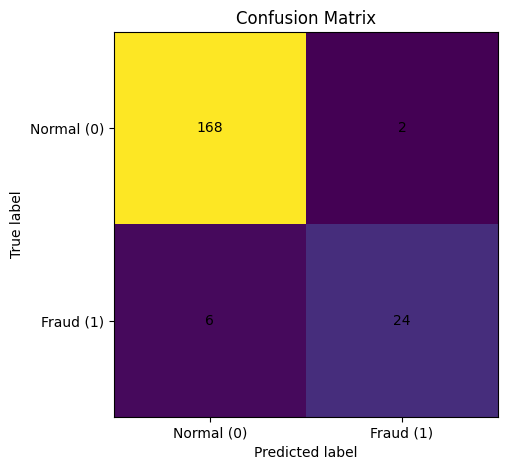

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# True vs predicted
y_true = df_out["is_fraud"].values
y_pred = df_out["predicted_fraud"].values

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Normal (0)", "Fraud (1)"])
ax.set_yticklabels(["Normal (0)", "Fraud (1)"])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


2. ROC Curve (classic ML graph)


“How well the model ranks fraud vs non-fraud across thresholds.”

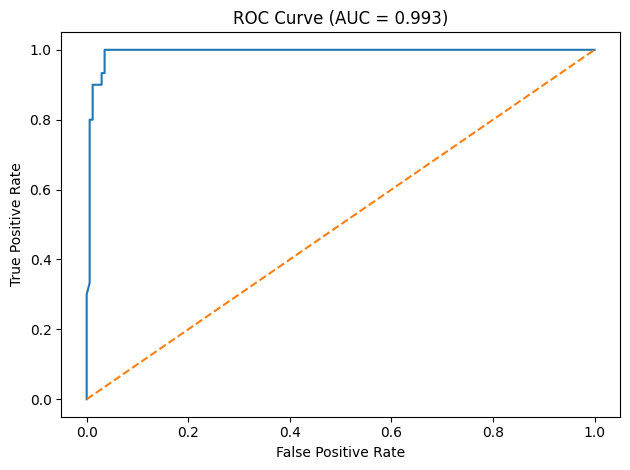

In [13]:
from sklearn.metrics import roc_curve, auc

y_true = df_out["is_fraud"].values
scores = df_out["final_score"].values  # or 'model_proba'

fpr, tpr, thresholds = roc_curve(y_true, scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.tight_layout()
plt.show()


3. Precision–Recall Curve (important for imbalanced fraud)


“How precision drops when we try to catch more fraud.”

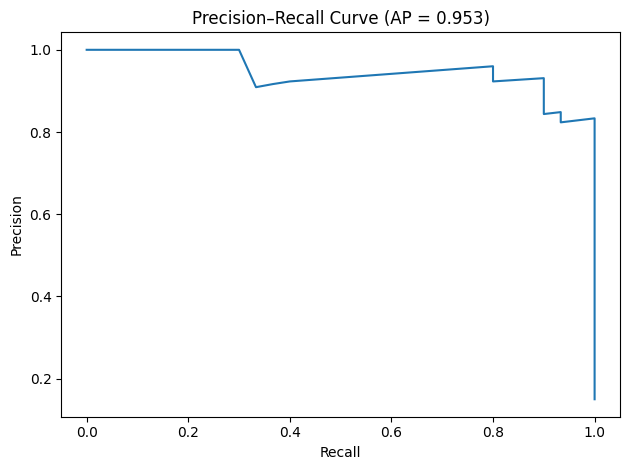

In [14]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_true = df_out["is_fraud"].values
scores = df_out["final_score"].values  # or 'model_proba'

precision, recall, thresholds = precision_recall_curve(y_true, scores)
ap = average_precision_score(y_true, scores)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {ap:.3f})")
plt.tight_layout()
plt.show()


5. Score Distribution: fraud vs non-fraud


“How final_score spreads for fraud vs normal — visual separation.”

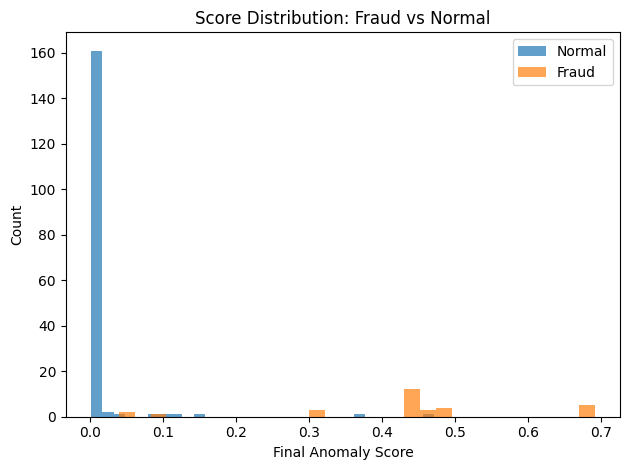

In [15]:
fraud_scores = df_out.loc[df_out["is_fraud"] == 1, "final_score"]
normal_scores = df_out.loc[df_out["is_fraud"] == 0, "final_score"]

plt.figure()
plt.hist(normal_scores, bins=30, alpha=0.7, label="Normal")
plt.hist(fraud_scores, bins=30, alpha=0.7, label="Fraud")
plt.xlabel("Final Anomaly Score")
plt.ylabel("Count")
plt.title("Score Distribution: Fraud vs Normal")
plt.legend()
plt.tight_layout()
plt.show()
